In [1]:
import os, pathlib, time, copy, librosa, gc

import torch
import torchaudio
import torch.nn as nn
import torchaudio.transforms as T
from torch import autocast
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from models.ConformerCls import ConformerCls
# import torchaudio.functional as F
# from torchaudio import datasets, models, info

import numpy as np
import matplotlib.pyplot as plt
import wandb

from rich_logger import RichTablePrinter
from tqdm import trange
from rich import pretty
from rich.console import Console
from IPython.display import Audio
from utils.audio_dataloader import MiniSpeechCommands
from utils.transformer_lrscheduler import TransformerLrScheduler

console = Console()
pretty.install()
plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    device = 'cuda'
    print("Using CUDA")
else:
    device = 'cpu'
    print('Using CPU')

Using CUDA


In [2]:
wandb.init(
    project="Conformer-SpeechClassifier",
    config={
        "dropout": .1,
        "attention_heads": 4,
        "input_dim": 80,
        "model_dim": 144,
        "ffn_expansion_factor": 4,
        "depthwise_conv_kernel_size": 31,
        "num_conformer_layers": 16,
        "num_lstm_layers": 1,
        "num_lstm_hidden": 320,
        "num_classes": 8,
        
        "mixed_precision": False,
        "epochs": 100,
        "batch_size": 512,
        "lr": 5e-4,
        "betas": (.9, .98),
        "eps": 1e-09,
        "weight_decay": 1e-6,
        "warmup_steps": 10000,
    }
) # eps = 1e-05 if use amp if not use 1e-09
config = wandb.config

wandb: Currently logged in as: enemyr. Use `wandb login --relogin` to force relogin


In [3]:
def plot_waveform(waveform, sample_rate, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

    
def visualize_file(file: str):
    metadata = torchaudio.info(file)
    wav, sr = torchaudio.load(file)
    console.log(metadata)
    console.log(wav, wav.shape)
    title = '/'.join(file.split('/')[-2:])
    plot_waveform(wav, sr, title)
    plot_specgram(wav, sr, title)

[08:15:30] AudioMetaData(sample_rate=16000, num_frames=16000, num_channels=1, bits_per_sample=16,  ]8;id=66471;file:///tmp/ipykernel_826495/1836796892.py\1836796892.py]8;;\:]8;id=223259;file:///tmp/ipykernel_826495/1836796892.py#46\46]8;;\
           encoding=PCM_S)                                                                                         

           tensor([[0.0004, 0.0016, 0.0002,  ..., 0.0029, 0.0029, 0.0017]])                        ]8;id=183196;file:///tmp/ipykernel_826495/1836796892.py\1836796892.py]8;;\:]8;id=64436;file:///tmp/ipykernel_826495/1836796892.py#47\47]8;;\
           torch.Size([1, 16000])                                                                                  

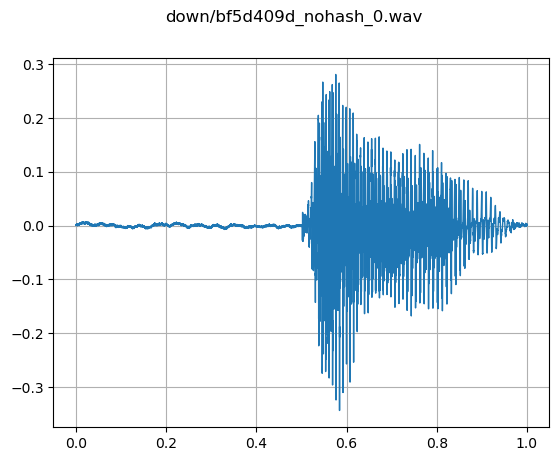

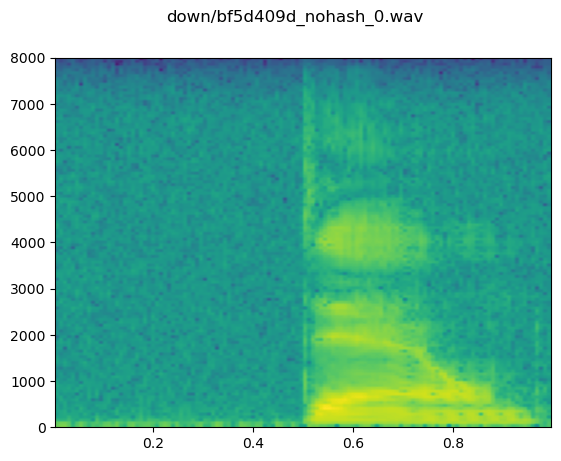

In [4]:
test_file = './datasets/speech-handsign_commands/speech/val/down/bf5d409d_nohash_0.wav'
visualize_file(test_file)
wav, sr = torchaudio.load(test_file)
Audio(wav.numpy()[0], rate=sr)

In [5]:
data_dir = './datasets/speech-handsign_commands/speech'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

def collate_fn(batch):
    spectrograms = []
    labels = []
    input_lengths = []
    for spec, label in batch:
        spectrograms.append(spec)
        labels.append(label)
        input_lengths.append(((spec.shape[0] - 1) // 2 - 1) // 2)
    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    labels = torch.tensor(labels)
    input_lengths = torch.tensor(input_lengths)
    return spectrograms, input_lengths, labels

time_masks = [T.TimeMasking(time_mask_param=15, p=.05) for _ in range(10)]
data_transform = {
    TRAIN: torch.nn.Sequential(
        T.MelSpectrogram(sample_rate=16000, n_mels=80, hop_length=160),#80 filter banks, 25ms window size, 10ms hop
        T.FrequencyMasking(freq_mask_param=27),
        *time_masks
    ),
    VAL: T.MelSpectrogram(sample_rate=16000, n_mels=80, hop_length=160),
    TEST: T.MelSpectrogram(sample_rate=16000, n_mels=80, hop_length=160)
}

speech_datasets = {
    x: MiniSpeechCommands(os.path.join(data_dir, x), transform=data_transform[x])
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(speech_datasets[x], batch_size=config.batch_size, shuffle=True, num_workers=14, collate_fn=collate_fn)  #os.cpu_count() = 24
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = { x: len(speech_datasets[x]) for x in [TRAIN, VAL, TEST] }
class_names = speech_datasets[TRAIN].classes

for x in [TRAIN, VAL, TEST]:
    console.log("Loaded {} audios under {}".format(dataset_sizes[x], x))
console.log("Classes: ", class_names)

           Loaded 5760 audios under train                                                          ]8;id=861248;file:///tmp/ipykernel_826495/1702399459.py\1702399459.py]8;;\:]8;id=231249;file:///tmp/ipykernel_826495/1702399459.py#44\44]8;;\

           Loaded 640 audios under val                                                             ]8;id=711327;file:///tmp/ipykernel_826495/1702399459.py\1702399459.py]8;;\:]8;id=548598;file:///tmp/ipykernel_826495/1702399459.py#44\44]8;;\

           Loaded 1600 audios under test                                                           ]8;id=139690;file:///tmp/ipykernel_826495/1702399459.py\1702399459.py]8;;\:]8;id=458258;file:///tmp/ipykernel_826495/1702399459.py#44\44]8;;\

           Classes:                                                                                ]8;id=358594;file:///tmp/ipykernel_826495/1702399459.py\1702399459.py]8;;\:]8;id=393249;file:///tmp/ipykernel_826495/1702399459.py#45\45]8;;\
           ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']                                              

[08:15:33] torch.Size([512, 101, 80])                                                               ]8;id=970817;file:///tmp/ipykernel_826495/3840278624.py\3840278624.py]8;;\:]8;id=198289;file:///tmp/ipykernel_826495/3840278624.py#2\2]8;;\
           torch.Size([512])                                                                                       

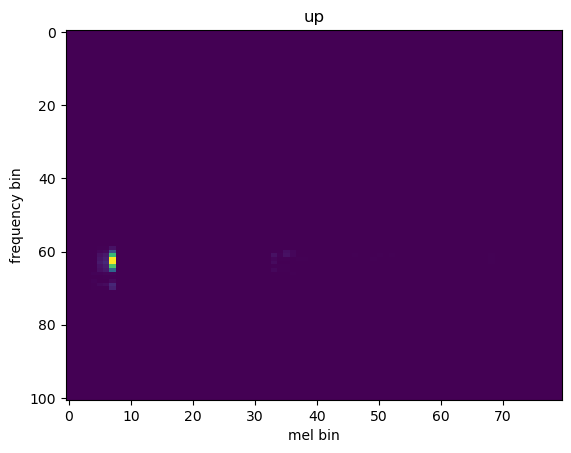

In [6]:
inputs, input_lengths, classes = next(iter(dataloaders[TRAIN]))
console.log(inputs.shape, classes.shape)
plot_fbank(inputs[0], class_names[classes[0]])

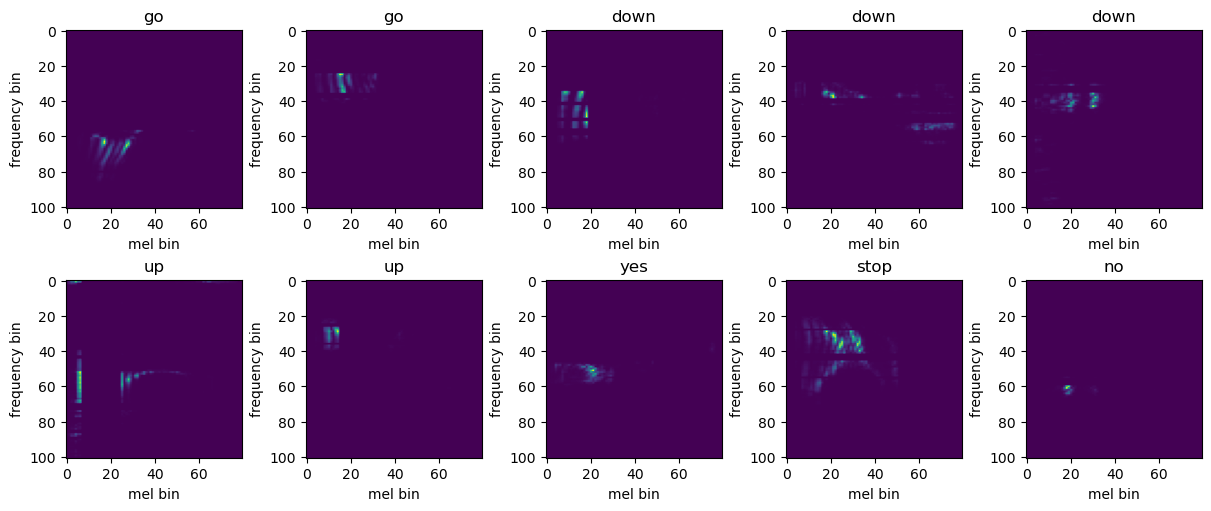

In [7]:
def visualize_batch(inps, titles=None):
    rows = 2
    cols = 5
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 5), constrained_layout=True)
    for idx, ax in enumerate(axs.ravel()):
        ax.set_title(titles[idx] or "Filter bank")
        ax.set_xlabel("mel bin")
        ax.set_ylabel("frequency bin")
        ax.imshow(inps[idx], aspect="auto")
    plt.show(block=False)
# Get a batch of training data
inputs, input_lengths, classes = next(iter(dataloaders[TRAIN]))
visualize_batch(inputs[::13], [class_names[x] for x in classes])

In [8]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct/len(y_pred)
    return acc

def train(model, criterion, optimizer, scheduler, scaler, dataloader):
    model.train()
    losses = 0
    accs = 0
    for i, batch in enumerate(dataloader):
        gc.collect()
        optimizer.zero_grad()
        inputs, input_lengths, classes = batch
        inputs = inputs.to(device)
        input_lengths = input_lengths.to(device)
        classes = classes.to(device).float()
        with autocast(enabled=config.mixed_precision, device_type=device):
            logit_outputs = model(inputs, input_lengths)
            pred_classes = torch.softmax(logit_outputs, dim=1).argmax(dim=1).float()
            loss = criterion(pred_classes, classes)
            loss.requires_grad = True
            acc = accuracy_fn(classes, pred_classes)
            losses += loss.item()
            accs += acc
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
    if use_gpu:
        torch.cuda.empty_cache()
    return {
        "train/loss": losses/dataset_sizes[TRAIN],
        "train/acc": accs/dataset_sizes[TRAIN]
    }

def validate(model, criterion, dataloader):
    model.eval()
    losses = 0
    accs = 0
    for i, batch in enumerate(dataloader):
        gc.collect()
        inputs, input_lengths, classes = batch
        inputs = inputs.to(device)
        input_lengths = input_lengths.to(device)
        classes = classes.to(device).float()
        with torch.inference_mode():
            with autocast(enabled=config.mixed_precision, device_type=device):
                logit_outputs = model(inputs, input_lengths)
                pred_classes = torch.softmax(logit_outputs, dim=1).argmax(dim=1).float()
                loss = criterion(pred_classes, classes)
                acc = accuracy_fn(classes, pred_classes)
                losses += loss.item()
                accs += acc
    if use_gpu:
        torch.cuda.empty_cache()
    return {
        "val/loss": losses/dataset_sizes[VAL],
        "val/acc": accs/dataset_sizes[VAL]
    }

def evaluation(model, criterion, dataloader):
    model.eval()
    losses = 0
    accs = 0
    for i, batch in enumerate(dataloader):
        gc.collect()
        inputs, input_lengths, classes = batch
        inputs = inputs.to(device)
        input_lengths = input_lengths.to(device)
        classes = classes.to(device).float()
        with torch.inference_mode():
            with autocast(enabled=config.mixed_precision, device_type=device):
                logit_outputs = model(inputs, input_lengths)
                pred_classes = torch.softmax(logit_outputs, dim=1).argmax(dim=1).float()
                loss = criterion(pred_classes, classes)
                acc = accuracy_fn(classes, pred_classes)
                losses += loss.item()
                accs += acc
    if use_gpu:
        torch.cuda.empty_cache()
    return {
        "eval/loss": losses/dataset_sizes[TEST],
        "eval/acc": accs/dataset_sizes[TEST]
    }

In [9]:
def run_optimization_loop():
    logger_fields = {
        "epoch": {},
        "tr/loss": {
            "goal": "lower_is_better",
            "format": "{:.6f}",
            "name": r"train/loss",
        },
        "va/loss": {
            "goal": "lower_is_better",
            "format": "{:.6f}",
            "name": r"val/loss",
        },
        "tr/acc": {
            "goal": "higher_is_better",
            "format": "{:.6f}",
            "name": r"train/acc",
        },
        "va/acc": {
            "goal": "higher_is_better",
            "format": "{:.6f}",
            "name": r"val/acc",
        },
        "duration": {"format": "{:.1f}", "name": "dur(s)"},
        ".*": True,  # Any other field must be logged at the end
    }
    printer = RichTablePrinter(key="epoch", fields=logger_fields)
    printer.hijack_tqdm()
    
    conformer_classifier = ConformerCls(
        d_input = config.input_dim,
        d_model = config.model_dim,
        dropout = config.dropout,
        num_heads = config.attention_heads,
        ffn_expansion_factor = config.ffn_expansion_factor,
        depthwise_conv_kernel_size = config.depthwise_conv_kernel_size,
        num_conformer_layers = config.num_conformer_layers,
        num_lstm_layers = config.num_lstm_layers,
        num_lstm_hidden = config.num_lstm_hidden,
        num_classes = config.num_classes
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(conformer_classifier.parameters(), lr=config.lr, betas=config.betas, eps=config.eps, weight_decay=config.weight_decay)
    scheduler = TransformerLrScheduler(optimizer, config.model_dim, config.warmup_steps)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    scaler = GradScaler(enabled=config.mixed_precision)
    # criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    # optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
    # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    gc.collect()
    if use_gpu:
        torch.cuda.set_device(0)

    start_t = time.time()
    for epoch in trange(config.epochs):
        wandb.watch(conformer_classifier, criterion, log_freq=1000)
        if use_gpu:
            torch.cuda.empty_cache()
        t = time.time()
        train_metrics = train(conformer_classifier, criterion, optimizer, scheduler, scaler, dataloaders[TRAIN])
        printer.log(
            {
                "epoch": epoch,
                "tr/loss": train_metrics['train/loss'],
                "tr/acc": train_metrics['train/acc'],
            }
        )
        val_metrics = validate(conformer_classifier, criterion, dataloaders[VAL])
        printer.log(
            {
                "epoch": epoch,
                "va/loss": val_metrics['val/loss'],
                "va/acc": val_metrics['val/acc'],
                "duration": time.time() - t,
            }
        )
        wandb.log(
            {
                "epoch": epoch,
                **train_metrics,
                **val_metrics
            }
        )
    printer.finalize()
    elapsed_time = time.time() - start_t
    console.log("Total Time Used : {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    start_e = time.time()
    eval_metrics = evaluation(conformer_classifier, criterion, dataloaders[TEST])
    elapsed_time = time.time() - start_e
    console.log("Average loss on Test set : {:.6f}".format(eval_metrics['eval/loss']))
    console.log("Average accuracy on Test set : {:.6f}".format(eval_metrics['eval/acc']))
    console.log("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    wandb.summary['test_loss'] = eval_metrics['eval/loss']
    wandb.summary['test_accuracy'] = eval_metrics['eval/acc']
    wandb.finish()
    return conformer_classifier

In [ ]:
model = run_optimization_loop()

┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ epoch ┃ train/loss ┃ val/loss  ┃ train/acc ┃ val/acc  ┃ dur(s) ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0     │ 28.741233  │ 30.594850 │ 0.000270  │ 0.000336 │ 3.6    │
│ 1     │ 28.840092  │ 29.606042 │ 0.000267  │ 0.000272 │ 3.2    │
│ 2     │ 28.830977  │ 29.474985 │ 0.000276  │ 0.000342 │ 3.3    │
│ 3     │ 28.791549  │ 29.339267 │ 0.000254  │ 0.000385 │ 3.3    │
│ 4     │ 28.789252  │ 28.943837 │ 0.000261  │ 0.000467 │ 3.4    │
│ 5     │ 28.750857  │ 28.482730 │ 0.000266  │ 0.000394 │ 3.3    │
│ 6     │ 28.660582  │ 28.028256 │ 0.000275  │ 0.000436 │ 3.4    │
│ 7     │ 28.835487  │ 27.922719 │ 0.000276  │ 0.000433 │ 3.3    │
│ 8     │ 28.782361  │ 27.818597 │ 0.000269  │ 0.000430 │ 3.5    │
│ 9     │ 28.757848  │ 27.899559 │ 0.000264  │ 0.000449 │ 3.4    │
│ 10    │ 28.768040  │ 27.870713 │ 0.000274  │ 0.000439 │ 3.6    │
│ 11    │ 28.758763  │ 27.936602 │ 0.000274  │ 0.000381 │ 3.6    │
│ 12    │ 28.815836  │ 27.946405 │ 0.000267  │ 0.000394 │ 3.5    │
│ 13    │ 28.761765  │ 27.843485 │ 0.000262  │ 0.000439 │ 3.5    │
│ 14    │ 28.828592  │ 27.886422 │ 0.000275  │ 0.000449 │ 3.4    │
│ 15    │ 28.730318  │ 27.963071 │ 0.000264  │ 0.000430 │ 3.4    │
│ 16    │ 28.814258  │ 27.921803 │ 0.000254  │ 0.000412 │ 3.4    │
│ 17    │ 28.776154  │ 27.831128 │ 0.000276  │ 0.000439 │ 3.4    │
│ 18    │ 28.775172  │ 27.779191 │ 0.000278  │ 0.000421 │ 3.5    │
│ 19    │ 28.781586  │ 27.877420 │ 0.000278  │ 0.000378 │ 3.5    │
│ 20    │ 28.930838  │ 27.852026 │ 0.000258  │ 0.000458 │ 3.4    │
│ 21    │ 28.835678  │ 27.838050 │ 0.000263  │ 0.000424 │ 3.7    │
│ 22    │ 28.745251  │ 27.869608 │ 0.000274  │ 0.000412 │ 3.5    │
│ 23    │ 28.811052  │ 27.940242 │ 0.000270  │ 0.000412 │ 3.6    │
│ 24    │ 28.701448  │ 27.807426 │ 0.000273  │ 0.000443 │ 3.6    │
│ 25    │ 28.862720  │ 27.813535 │ 0.000259  │ 0.000415 │ 3.5    │
│ 26    │ 28.859660  │ 27.894035 │ 0.000268  │ 0.000409 │ 3.5    │
│ 27    │ 28.823513  │ 27.788798 │ 0.000264  │ 0.000415 │ 3.5    │
│ 28    │ 28.865783  │ 27.972312 │ 0.000254  │ 0.000385 │ 3.8    │
│ 29    │ 28.787762  │ 27.965902 │ 0.000264  │ 0.000461 │ 3.9    │
│ 30    │ 28.809606  │ 27.859047 │ 0.000272  │ 0.000455 │ 3.7    │
│ 31    │ 28.783174  │ 28.042877 │ 0.000276  │ 0.000458 │ 3.8    │
│ 32    │ 28.885369  │ 27.869614 │ 0.000255  │ 0.000391 │ 3.7    │
│ 33    │ 28.862181  │ 27.890573 │ 0.000264  │ 0.000424 │ 3.6    │
│ 34    │ 28.904717  │ 28.023743 │ 0.000265  │ 0.000488 │ 3.6    │
│ 35    │ 28.709159  │ 27.832567 │ 0.000269  │ 0.000500 │ 3.9    │
│ 36    │ 28.833190  │ 27.867568 │ 0.000269  │ 0.000446 │ 3.7    │
│ 37    │ 28.754188  │ 27.849603 │ 0.000269  │ 0.000378 │ 4.0    │
│ 38    │ 28.814366  │ 27.758297 │ 0.000259  │ 0.000488 │ 3.7    │
│ 39    │ 28.713974  │ 27.881504 │ 0.000273  │ 0.000494 │ 3.8    │
│ 40    │ 28.710190  │ 27.978831 │ 0.000265  │ 0.000418 │ 3.9    │
│ 41    │ 28.743692  │ 27.944889 │ 0.000279  │ 0.000482 │ 3.7    │
│ 42    │ 28.824414  │ 27.948983 │ 0.000255  │ 0.000403 │ 4.0    │
│ 43    │ 28.817665  │ 27.991512 │ 0.000262  │ 0.000424 │ 4.0    │
│ 44    │ 28.779018  │ 27.931078 │ 0.000266  │ 0.000461 │ 3.8    │
│ 45    │ 28.770800  │ 27.837929 │ 0.000261  │ 0.000424 │ 3.8    │
│ 46    │ 28.709198  │ 27.934821 │ 0.000262  │ 0.000369 │ 3.8    │
│ 47    │ 28.883012  │ 27.828142 │ 0.000258  │ 0.000403 │ 3.9    │
│ 48    │ 28.750873  │ 27.790172 │ 0.000270  │ 0.000430 │ 3.9    │
│ 49    │ 28.910631  │ 27.979613 │ 0.000266  │ 0.000418 │ 3.9    │
│ 50    │ 28.812916  │ 27.916515 │ 0.000253  │ 0.000397 │ 3.9    │
│ 51    │ 28.782662  │ 27.817121 │ 0.000254  │ 0.000458 │ 4.1    │
│ 52    │ 28.815876  │ 27.751035 │ 0.000268  │ 0.000439 │ 4.1    │
│ 53    │ 28.724289  │ 27.888028 │ 0.000265  │ 0.000433 │ 4.0    │
│ 54    │ 28.859629  │ 27.758231 │ 0.000259  │ 0.000397 │ 4.2    │
│ 55    │ 28.785483  │ 27.894940 │ 0.000264  │ 0.000424 │ 4.2    │
│ 56    │ 28.653228  │ 27.869378 │ 0.000266  │ 

In [ ]:
torch.save(model.state_dict(), './weights/conformer_classifier_bn.pt')

In [ ]:
torch.onnx.export(model, (inputs[0].unsqueeze(0).cuda(), input_lengths[0].unsqueeze(0).cuda()), "./weights/conformer_classifier_model.onnx")